In [2]:
!pip install qiskit
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

import qiskit
from qiskit.visualization import *


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 14.1 MB/s eta 0:00:00


In [3]:

use_cuda = torch.cuda.is_available()
print('CUDA available:', use_cuda)

if use_cuda:
  device = torch.device('cuda')
  print('Training on GPU...')

else:
  device = torch.device('cpu')
  print('Training on CPU...')



CUDA available: False
Training on CPU...


In [4]:
class QuantumCircuit:
    """
    This class provides a simple interface for interaction
    with the quantum circuit
    """

    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)

        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')

        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)

        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()

        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)

        return np.array([expectation])

In [9]:

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *


In [51]:
!pip install qiskit-aer

from qiskit_aer import AerSimulator

simulator = AerSimulator()

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()


Expected value for rotation pi 0.55


<ipython-input-4-6a3097f83179>:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

In [14]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs:
            expectation_z.append(ctx.quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z).cuda()

        ctx.save_for_backward(inputs, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())

        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift

        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])

            gradient = torch.tensor([expectation_right]).cuda() - torch.tensor([expectation_left]).cuda()
            gradients.append(gradient)

        # gradients = np.array([gradients]).T
        gradients = torch.tensor([gradients]).cuda()
        gradients = torch.transpose(gradients, 0, 1)

        # return torch.tensor([gradients]).float() * grad_output.float(), None, None
        return gradients.float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [15]:
n_samples = 512
batch_size = 256

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

X_train.data = X_train.data[:n_samples]
X_train.targets = X_train.targets[:n_samples]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
# check MNIST data

100%|██████████| 9912422/9912422 [00:00<00:00, 149390093.69it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 64194856.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 73105128.82it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1617192.59it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



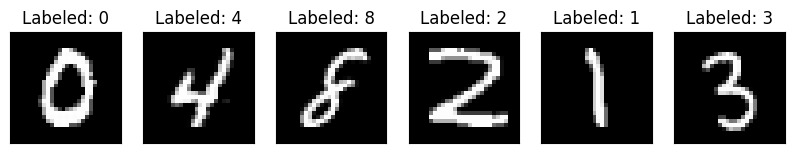

In [16]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

images, targets = data_iter.__next__()


while n_samples_show > 0:
    axes[n_samples_show - 1].imshow(images[n_samples_show].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(int(targets[n_samples_show])))

    n_samples_show -= 1

In [17]:
n_samples = 2048

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
#                 np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[:n_samples]
X_test.targets = X_test.targets[:n_samples]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True)


In [56]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)
        # Initialize Hybrid instances
        self.hybrid = [Hybrid(AerSimulator(), 100, np.pi / 2) for i in range(10)]

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [57]:
# Initialize the model on the CPU
model = Net()

# Display model summary
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
         Dropout2d-3             [-1, 16, 4, 4]               0
            Linear-4                   [-1, 64]          16,448
            Linear-5                   [-1, 10]             650
Total params: 19,670
Trainable params: 19,670
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.08
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [60]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 50
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Remove .cuda() calls
        # data = data.cuda()
        # target = target.cuda()

        # Forward pass
        output = model(data)  # Remove .cuda()

        # Calculating loss
        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


Training [2%]	Loss: 2.3044
Training [4%]	Loss: 2.2911
Training [6%]	Loss: 2.2760
Training [8%]	Loss: 2.2589
Training [10%]	Loss: 2.2378
Training [12%]	Loss: 2.2066
Training [14%]	Loss: 2.1664
Training [16%]	Loss: 2.1168
Training [18%]	Loss: 2.0463
Training [20%]	Loss: 1.9893
Training [22%]	Loss: 1.8750
Training [24%]	Loss: 1.7807
Training [26%]	Loss: 1.6749
Training [28%]	Loss: 1.5210
Training [30%]	Loss: 1.3806
Training [32%]	Loss: 1.2502
Training [34%]	Loss: 1.1667
Training [36%]	Loss: 1.0184
Training [38%]	Loss: 0.9401
Training [40%]	Loss: 0.8591
Training [42%]	Loss: 0.7898
Training [44%]	Loss: 0.7253
Training [46%]	Loss: 0.6748
Training [48%]	Loss: 0.6052
Training [50%]	Loss: 0.6223
Training [52%]	Loss: 0.5808
Training [54%]	Loss: 0.5457
Training [56%]	Loss: 0.5279
Training [58%]	Loss: 0.5214
Training [60%]	Loss: 0.5217
Training [62%]	Loss: 0.5127
Training [64%]	Loss: 0.4680
Training [66%]	Loss: 0.4549
Training [68%]	Loss: 0.4573
Training [70%]	Loss: 0.4177
Training [72%]	Loss: 0.4

Text(0, 0.5, 'Neg Log Likelihood Loss')

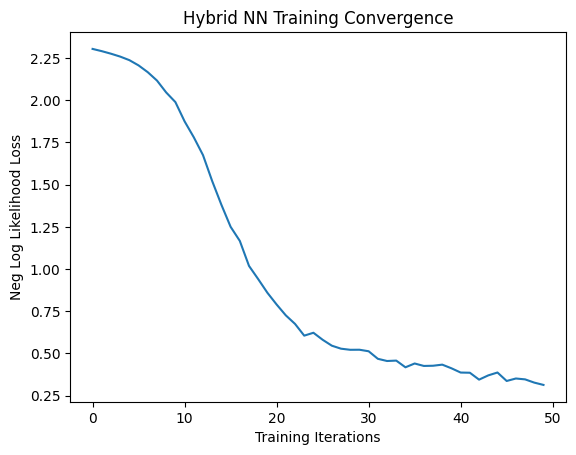

In [61]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [63]:
model.eval()
with torch.no_grad():

    correct = 0
    total_loss = []
    for batch_idx, (data, target) in enumerate(test_loader):

        # Remove .cuda() calls
        # data = data.cuda()
        # target = target.cuda()

        # Forward pass
        output = model(data)  # Remove .cuda()

        # Move predictions and targets to CPU for comparison
        pred = output.argmax(dim=1, keepdim=True).cpu()
        target = target.cpu()

        # Calculate accuracy
        correct += pred.eq(target.view_as(pred)).sum().item()

        # Calculate loss
        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader.dataset) * 100))


Performance on test data:
	Loss: 0.5369
	Accuracy: 83.4%


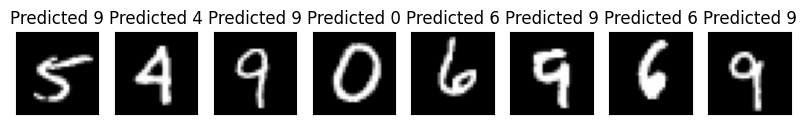

In [65]:
n_samples_show = 8
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break

        # Remove .cuda() calls
        # data_cuda = data.cuda()
        # target_cuda = target.cuda()

        # Forward pass
        output = model(data)  # Remove .cuda()

        # Move predictions and targets to CPU for plotting
        pred = output.argmax(dim=1, keepdim=True).cpu()
        data = data.cpu()

        axes[count].imshow(data[count].numpy().squeeze(), cmap='gray')
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred[count].item()))

        count += 1
